# 03 Train GAT
The `gat` module of SPARROW performs microenvironment zone inference via a latent representation $H$. The zone assignment is determined by a softmax operation on $H$. 
Note that at this step you should have successfully trained a SPARROW-VAE model. This traning step uses the latent representation $Z$ from SPARROW-VAE, and the spatial coordinates contaiend in the parquet files made by SPARROW. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch 
import umap
import sys
sys.path.append('/home/jupyter/tools/') #append the directory in which SPARROW is installed
import SPARROW

In [3]:
# Set the subdirectory in which you will save model outputs
my_model_dir = "test_model"
directory = f"/home/jupyter/sparrow_demo/{my_model_dir}"
if not os.path.exists (directory):
    os.makedirs(directory)


## GAT model training

In [5]:
# Load the sparrow object
obj=SPARROW.preprocessing.ingest.read_parquet('/home/jupyter/tools/SPARROW/testdata/HumanGutDemoData/parquet/')  


In [6]:
#check that obj is correctly read
obj.parquet

,x,y,min_x,min_y,max_x,max_y,ACE,ACE2,ADIPOR1,ADORA1,ADORA3,AKT3,ALDH2,ANKRD22,APOBEC1,APOBR,APOE,APOL1,APOL2,APP,BACE2,BACH2,BATF,BAX,BCL2,BHLHE40,CASP1,CASP3,CASP8,CCL2,CCL22,CCL5,CCND2,CCR1,CCR5,CD101,CD14,CD163,CD177,CD180,CD200,CD209,CD22,CD244,CD248,CD274,CD276,CD300A,CD300E,CD33,CD34,CD36,CD37,CD38,CD3G,CD4,CD40,CD44,CD47,CD55,CD59,CD79B,CD84,CD86,CD8A,CD93,CD96,CDH1,CDKN1C,CEACAM1,CEACAM5,CEBPD,CHAMP1,CHIC1,CLEC10A,CLEC14A,CLEC4E,CLEC7A,COL1A1,CR2,CX3CL1,CX3CR1,CXCL1,CXCL11,CXCL2,CXCL3,CXCL5,CXCL6,CXCL8,CXCL9,CXCR3,CXCR6,DAAM1,DHRS7B,DNASE1,DUOX2,DYNLL2,ELF3,ENG,ENTPD1,ENTPD2,ENTPD5,FAP,FFAR2,FGL2,FLT1,FN1,FOXO1,FOXO4,FOXP1,FOXP3,FZD3,FZD4,GATA2,GATA3,GATA6,GGT7,GLUD1,GNLY,GZMB,GZMH,HDAC1,HDAC3,HES1,HIF1A,HMGB3,HNRNPF,HNRNPLL,ICAM1,ICAM3,ICOS,IDO1,IFNAR1,IFNGR1,IKZF1,IKZF2,IKZF3,IL10RA,IL12RB1,IL15,IL15RA,IL17B,IL17RA,IL18,IL18R1,IL1B,IL1R1,IL1R2,IL1RN,IL21R,IL2RA,IL2RB,IL32,IL33,IL34,IL4R,IL6,IL7,IL7R,IRAK3,IRF1,IRF3,IRF4,IRF8,ITGAE,ITGAM,ITGAV,ITGAX,ITGB1,ITGB2,ITGB3,ITGB6,ITGB8,JAG1,JAK2,KLF4,KLF6,KLRB1,LCN2,LDLR,LEPR,LILRA1,LILRA2,LILRA5,LILRA6,LILRB1,LILRB2,LILRB3,LILRB4,LINC00467,LPL,LRG1,LTBR,MAMDC2,MBNL1,MCM9,MERTK,MESP1,MME,MMP1,MMP2,MMP3,MMP9,MR1,MS4A2,MUC1,MUC2,MXRA5,MYD88,MYDGF,MYLK,MYOF,NAIF1,NCAM1,NDUFAF2,NFATC3,NFKB1,NFKB2,NLRC3,NLRP3,NOD1,NOD2,NOTCH3,NOTCH4,NRP2,NT5E,P2RY1,PANX1,PAX5,PDGFB,PDGFRB,PDPN,PECAM1,PER1,PHLDA2,PLA2G2A,PLAU,PLAUR,PLCG2,PLIN1,PLIN2,PLIN4,POU2AF1,PRDM1,PRDX4,PRELP,PROX1,PURA,RAD51D,RELA,RORA,RUNX2,S100A12,S1PR1,SAMHD1,SDC1,SELENOM,SESN3,SFRP2,SHQ1,SLAMF6,SMAD1,SMAD3,SMAD6,SMAD7,SMTN,SOX9,SPI1,SPIB,STAT1,STAT2,STAT3,STAT4,STAT5A,STAT6,SUSD3,SYP,TAP1,TBX21,TCF7,TGFB1,TGFBR3,TLR1,TLR10,TLR2,TLR4,TLR5,TLR7,TLR8,TMED9,TNF,TOX3,TRAC,TSHZ1,TSPAN3,TSPO,UPP1,VEGFA,VEGFB,WARS,WNT1,WNT2B,WNT4,WNT5A,ZG16B,ZNF764
npartitions=6,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float

### Next we define the dimensions of our GAT model. 
In the example below, 84 is the input dimension. This should match that of $Z$ from the SPARROW-VAE. [64,48] is a dimension vector for the graph attention layers, [36,24,12] is a dimension vector for the fully connected layers and 3 is the number of attention heads. All these parameters can be fine tuned to improve the model performance.

In [7]:
GATmodel=SPARROW.GAT.neighbourhoods.minCUTPooling(84,[64,48],[36,24,12],3)

### Now let's load a list of spatial adjacencies and gene expression arrays. 
SPARROW takes care of this in the backend so simply specify the relevant parquet. One can always concatenate lists from several parquets.

In [8]:
#define the bounding box for the tissue area we want to train the GAT model on
xmin,xmax,ymin,ymax = obj.parquet['x'].min().compute(), obj.parquet['y'].max().compute() , obj.parquet['y'].min().compute(), obj.parquet['x'].max().compute() 


In [ ]:
#make the adjacency list, A_list, and the gene expression array list,X_list.
stepsize=4000
k_neighbours_for_adjacency = 4
min_transcript_per_cell = 5
A_list, X_list=SPARROW.GAT.preprocessing.graph_loader(obj, obj._genes_no_blank,int(xmin),int(xmax),int(ymin),int(ymax),stepsize,
                                                      k_neighbours_for_adjacency,min_transcript_per_cell
                                                     )

In [15]:
#check A_list and X_list are properly defined
len(A_list) == len(X_list)

True

### load the previously trained VAEmodel
To train GAT, we will need to use the latent representation $Z$ from the trained VAE model as node features. To do so, load the trained VAE model:

In [ ]:
#this should be the same as how VAE model was previously defined
VAEmodel=SPARROW.VAE.vae.vae(X_list[0].shape[1],[160,84],[64,32,14])
#load saved model weights
VAEmodel.load_state_dict(torch.load('sparrow_demo/test_model/vae_model.pkl'))

### start GAT training

In [ ]:
optimizer_gat = torch.optim.Adam(GATmodel.parameters(), lr=5e-3,weight_decay=1e-5)
SPARROW.GAT.neighbourhoods.train(GATmodel,VAEmodel, optimizer_gat,A_list,X_list,num_epochs=200,log_name='GATtraining.log')


## GAT application
Once GAT model is trained, its parameters are ready to be saved for future loading and application.

In [57]:
#save GATmodel
#torch.save(GATmodel.state_dict(),'sparrow_demo/test_model/GAT_model.pkl')
#make sure GATmodel is in evaluation mode
#In the demo below, I'm using a VAE and GAT model trained previously on human intestine Xenium data that can be found in testdata
GATmodel.eval()
#define bounding box
xmin,xmax,ymin,ymax = 0,2000,4000,6000
#read human intestine parquet
obj=SPARROW.preprocessing.ingest.read_parquet('testdata/HumanGutDemoData/parquet/')
ROI = obj.geometry.cx[xmin:xmax,xmin:xmax]
#load gene features selected for VAE training 
#selected_features=np.load('/path/to/selected_VAE_gene_features.npy')

X= obj.parquet.compute().loc[ROI.index,selected_features].values
A=SPARROW.GAT.preprocessing._make_A(ROI,k=4)
with torch.no_grad():
    loc, scale = VAEmodel.Encoder(torch.from_numpy(X).type(torch.float))
    ###################################################
    #below, embeddings is a list representing the outcomes of  hierarchical graph coarsening to find microenvironment zones
    #the last element is used as the final, coarsest outcome for microenvironment zones.
    ###################################################
    embeddings = GATmodel(loc, A.coalesce().indices())

/home/jupyter/envs/spatial2/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)
/home/jupyter/envs/spatial2/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/jupyter/envs/spatial2/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/jupyter/envs/spatial2/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [58]:
#confirm that there are 12 zones as defined in box 7
embeddings[-1].shape

torch.Size([9091, 12])

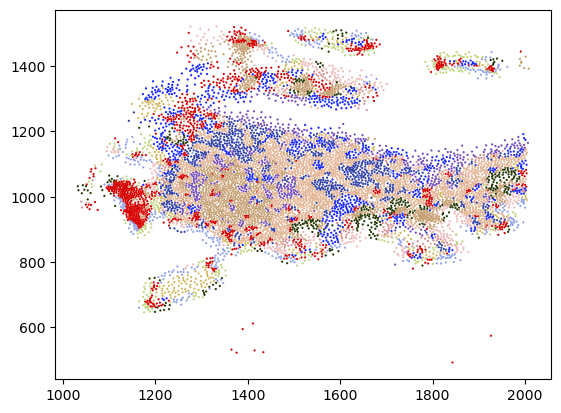

In [61]:
import colorcet
from matplotlib.pyplot import get_cmap
xy=obj.parquet.compute().loc[ROI.index,['x','y']].values
for i in range(12):
    plt.scatter(*xy[embeddings[-1].argmax(axis=1) == i].T,s=10,marker='.',edgecolors='none',color=get_cmap('cet_glasbey',12)(i))